In [1]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import xarray as xr

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Что такое этот ваш Байес?

У нас на руках монета, и нам кажется, что она не совсем честная. Подкинем ее 10 раз и запишем результаты

In [2]:
np.random.seed(42)
trials = 10 # число попыток
prob_real = 0.35 # неизвестная истинная вероятность
data = stats.bernoulli.rvs(p=prob_real, size=trials) # подбрасывание монеты

In [3]:
data.sum() / len(data)

0.4

Вроде монета нечестная, но стоит сравнить полученное распределение с эталонными. Чтобы сравнивать не точечные характеристики (средние и медианы), а распределения, используют байесовскую статистику

In [4]:
with pm.Model() as first_model:
    # предположим, что монета честная, потому выберем
    # равномерное распределение: бета-распределение с a=b
    # априор
    theta = pm.Beta('theta', alpha=1.0, beta=1.0)
    
    # Моделируем распределение Бернули с априорным представлением о честности монеты
    # то есть результаты равновероятны. А в observed указываем распределение,
    # полученные не от честной монеты
    # правдоподобие
    y = pm.Bernoulli('y', p=theta, observed=data)
    
    # генерируем 1000 выборок
    trace = pm.sample(1000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 13 seconds.


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

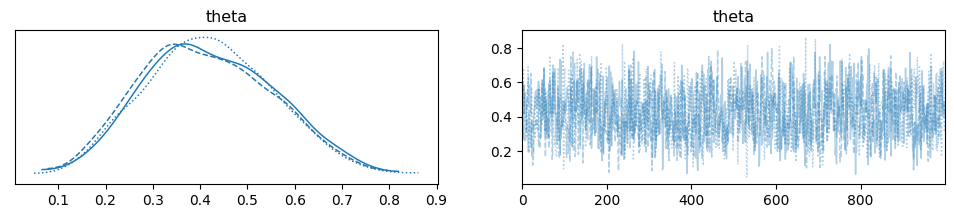

In [5]:
az.plot_trace(trace)

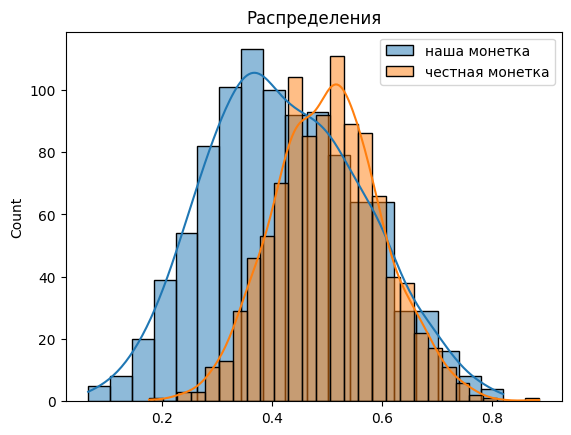

In [6]:
sns.histplot(trace.posterior.theta.values[0], kde=True, label='наша монетка')
sns.histplot(np.random.normal(0.5, 0.1, 1000), kde=True, label='честная монетка')
plt.title('Распределения')
plt.legend()
plt.show()

Распределение вероятности скошено влево от 0.5, что говорит о вероятной нечестности монеты. Иначе распределение было бы похоже нормальное, со средним в 0.5.

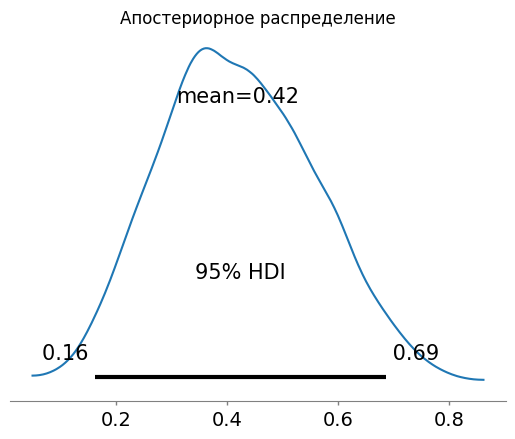

In [7]:
az.plot_posterior(trace, hdi_prob=0.95)
plt.title('Апостериорное распределение')
plt.show()

С 95% доверительным интервалом, истинная вероятность орла для нашей монеты лежит в пределах 0.16-0.69. Так как предположение о том, что монета честная, попадает в этот доверительный интервал (честная монета - 0.5, что соответствует 0.16<0.5<0.69), то мы не можем окончательно утверждать, что монета нечестная

# Химические сдвиги (выбросы)

У нас на руках есть значения химических сдвигов

In [8]:
chem_shift= np.array([
    51.06, 55.12, 53.73, 50.24, 52.05, 56.4 , 48.45, 52.34, 55.65,
    51.49, 51.86, 63.43, 53.  , 56.09, 51.93, 52.31, 52.33, 57.48,
    57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73,
    51.94, 54.95, 50.39, 52.91, 51.5 , 52.68, 47.72, 49.73, 51.82,
    54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42,
    54.3 , 53.84, 53.16
])

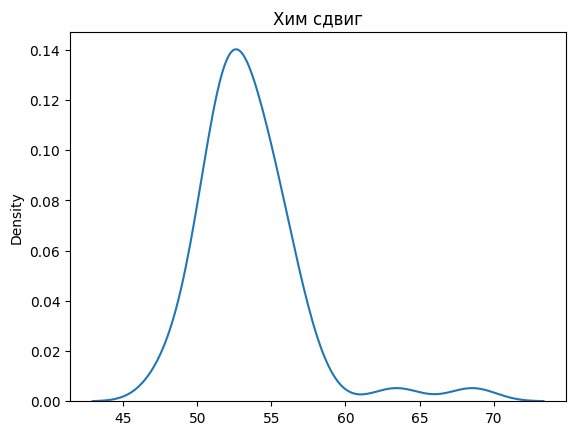

In [9]:
sns.kdeplot(chem_shift)
plt.title("Хим сдвиг")
plt.show()

In [10]:
print('Отклонение равно ', chem_shift.std())
print('Отклонение равно ', chem_shift.mean())

Отклонение равно  3.4200063898474258
Отклонение равно  53.49645833333333


Предположим, что данные должны быть распределены нормально. Мы не знаем среднего и дисперсии.  

Поэтому предположим, что среднее может быть от 40 до 70 с одинаковой вероятностью, а среднее - 0-10, причем вероятность быть ближе к 0 выше чем к 10

In [11]:
with pm.Model() as model_chem:
    
    mu = pm.Uniform(name='mean', lower=40, upper=70)
    # т.к. отклонение не может быть отрицательным, 
    # принимаем только половину от нормального распределения
    sigma = pm.HalfNormal(name='sigma', sigma=10)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=chem_shift)
    trace_chem = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mean, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 21 seconds.


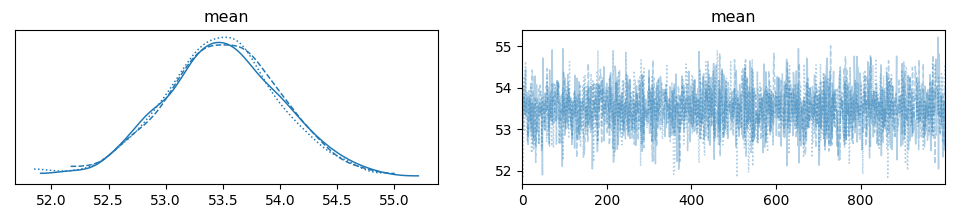

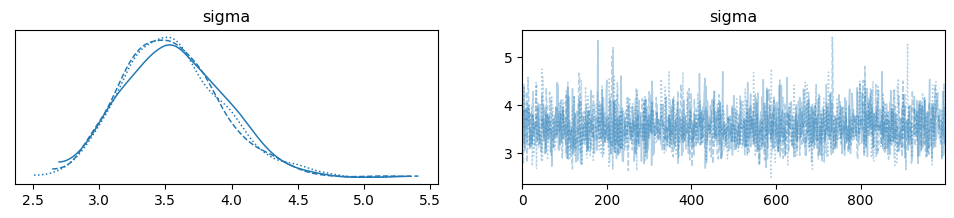

In [12]:
az.plot_trace(trace_chem, var_names='mean')
az.plot_trace(trace_chem, var_names='sigma')
plt.show()

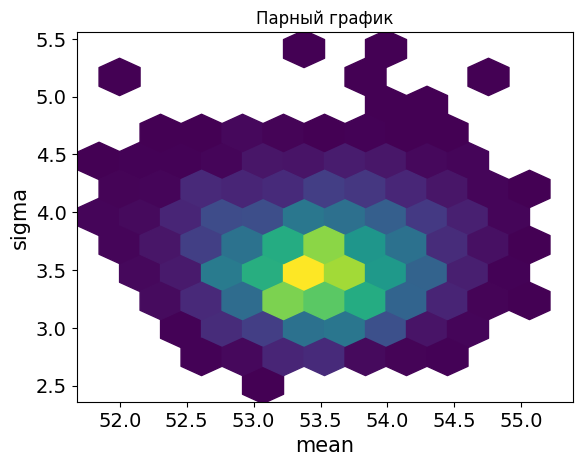

In [13]:
az.plot_pair(trace_chem, kind='hexbin')
plt.title('Парный график')
plt.show()

На совместном графике мы видим, что среднее лежит в пределах 53-54, а отклонение - 3.3-3.7 

In [14]:
y_pred = pm.sample_posterior_predictive(trace_chem,  model_chem, extend_inferencedata=True)

Sampling: [y]


c:\users\cripe\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


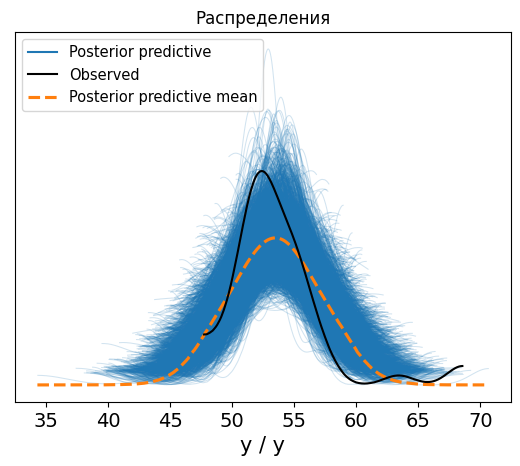

In [15]:
az.plot_ppc(y_pred)
plt.title('Распределения')
plt.show()

Черная линия - наблюдаемые данные, синии линии - предсказанные распределения данных, основанных на наших априрорных представлениях и наблюдаемых данных. Как мы видим, предсказанные данные (как и апостериорное среднее) смещены правее от среднего наблюдаемых данных. В наблюдаемых данных есть выбросы, которые могли потянуть выборку вправо

Стоит попробовать распределение Стьюдента, которое более устойчиво к выбросам 

Модель будет принимать те же самые априорные сведения, но т.к. распределение Стьюдента предполагает наличие степеней свободы. Чем больше выборка, тем больше число степеней свободы, тем точнее результаты. 

Возьмем экпоненциальное распределение со средним 30 ($\lambda={1\over30}$), т.к. 30 степеней свободы приблизительно аппроксимируют нормальное распределение, а значения ниже 30 (которые будут появляться при генерации выборок) будут влиять на апостериорное распределение

In [16]:
with pm.Model() as model_chem_2:
    
    mu = pm.Uniform(name='mean', lower=40, upper=70)
    sigma = pm.HalfNormal(name='sigma', sigma=10)
    
    v = pm.Exponential('v', 1/30)
    
    y = pm.StudentT('y_tdist', mu=mu, sigma=sigma, nu=v, observed=chem_shift)
    trace_chem_t = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mean, sigma, v]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 69 seconds.


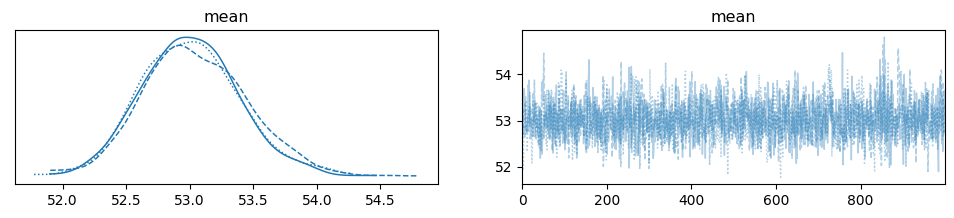

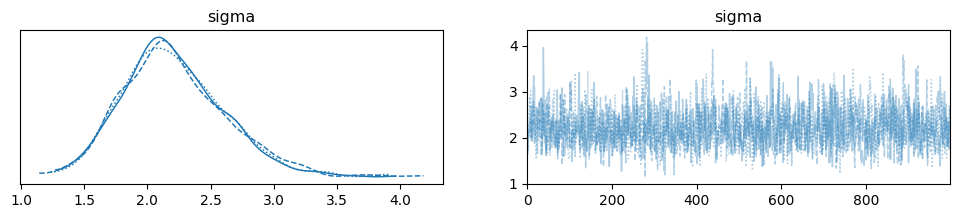

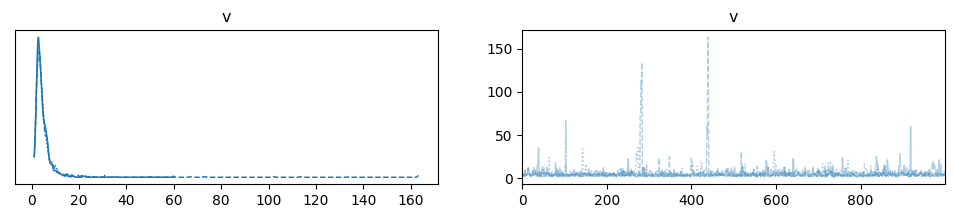

In [17]:
az.plot_trace(trace_chem_t, var_names='mean')
az.plot_trace(trace_chem_t, var_names='sigma')
az.plot_trace(trace_chem_t, var_names='v')
plt.show()

In [19]:
# было с нормальным распределением
print('Нормальное распределение')
display(az.summary(trace_chem))
# стало с распределением Стьюдента
print('Распределение Стьюдента')
display(az.summary(trace_chem_t))

Нормальное распределение


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,53.493,0.513,52.499,54.418,0.010,0.007,2454.0,1868.0,1.0
sigma,3.556,0.381,2.862,4.259,0.008,0.006,2119.0,1654.0,1.0


Распределение Стьюдента


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,53.022,0.402,52.304,53.814,0.009,0.007,1944.0,1367.0,1.0
sigma,2.214,0.410,1.532,3.029,0.012,0.009,1313.0,1475.0,1.0
v,4.991,6.914,1.269,10.147,0.240,0.170,1249.0,1139.0,1.0


Среднее практически не изменилось, но увеличилась уверенность модели - среднее стандартного отклонение уменьшилось на 40%, а верхний предел 94% доверительного интервала расрпделение Стьюдента практически равен нижнему при нормальном распределении, что говорит о большей уверенности модели.  
Число степенй свободы приблизительно равно 5, что позыоляет говорить об отличии от нормального распределения

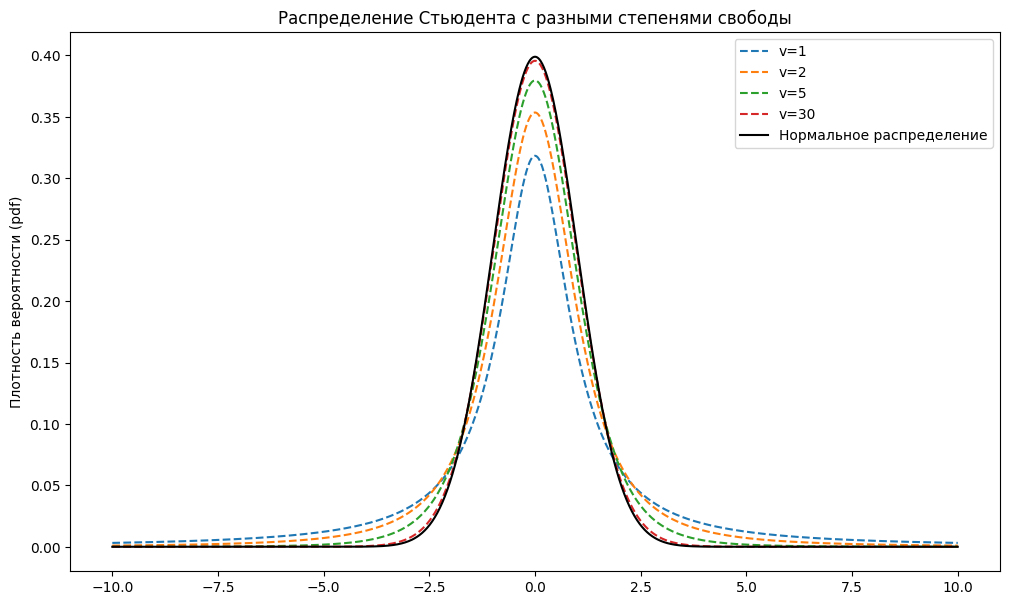

In [21]:
x = np.linspace(-10, 10, 1000)
plt.figure(figsize=(12, 7))
for df in [1, 2, 5, 30]:
    
    tdist = stats.t(df=df)
    sns.lineplot(x=x, y=tdist.pdf(x), linestyle='--', label=f'v={df}')

sns.lineplot(x=x, y=stats.norm().pdf(x), label='Нормальное распределение', color='black') 
plt.ylabel('Плотность вероятности (pdf)')
plt.title('Распределение Стьюдента с разными степенями свободы')
plt.show()

Меньшее число степеней свободы обладает более "тяжелыми" хвостами, что значит отклонения не так сильно на него влияют, т.к. при подобнос распределении появление таких значений вероятнее чем в нормальном

Sampling: [y_tdist]


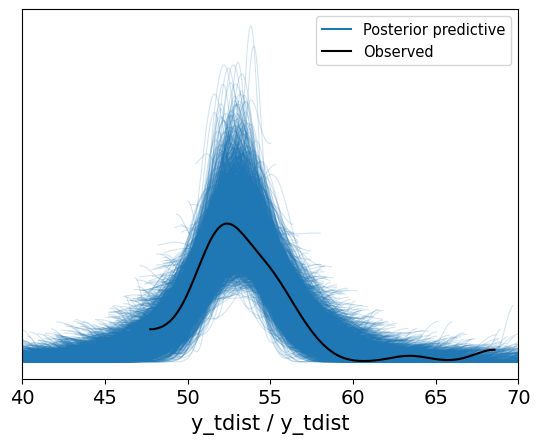

In [22]:
y_pred_t = pm.sample_posterior_predictive(trace_chem_t,  model_chem_2, random_seed=42)
az.plot_ppc(y_pred_t, mean=False)
plt.xlim(40, 70)
plt.show()

Распределение Стьюдента лучше аппрокисимирует данные: постериорные предсказания имеют более острый колокол по сравнению с нормальным распределением, а также их более высокая плотность. Смещение, присущее нормальному распределению, тут заметно меньше

# GLM (Generalized Linear Model)

Ряд моделей, устойчивых к выбросам

In [27]:
# генерация выборки линейной регресси
n = 100
true_slope = 1
true_intercept = 2
error = np.random.normal(0, 0.3, size=103)

data = np.linspace(0, 1, n)
y = data * true_slope + true_intercept

# выбросы
data = np.append(data, [0.1, 0.15, 0.3])
y = np.append(y, [8, 6, 9])

y_true = y + error

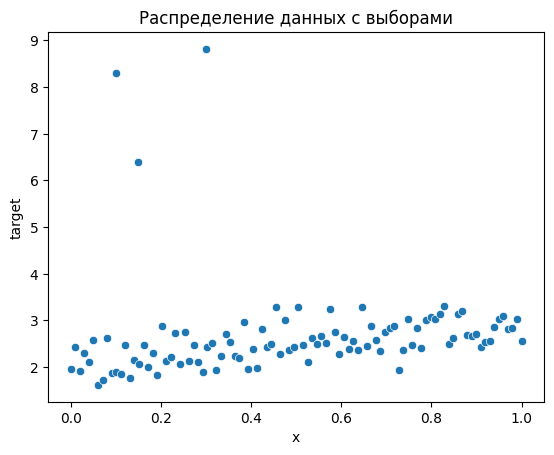

In [28]:
sns.scatterplot(y=y_true, x=data)
plt.title('Распределение данных с выборами')
plt.xlabel('x')
plt.ylabel('target')
plt.show()

In [29]:
# строим простую регрессию
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(data.reshape(-1,1), y_true.reshape(-1,1))

slope_coef = model.coef_
intercept_coef = model.intercept_
y_pred = data * slope_coef + intercept_coef

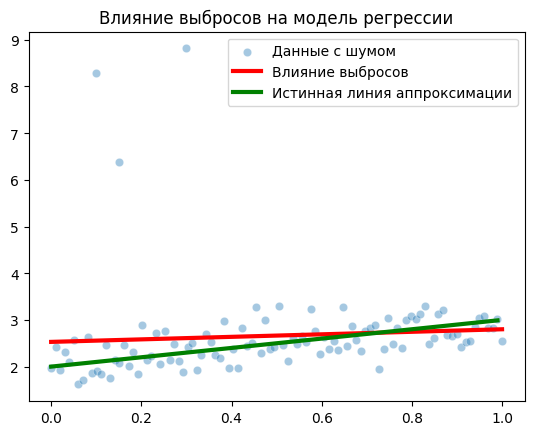

In [31]:
sns.scatterplot(x=data, y=y_true, label='Данные с шумом', alpha=0.4)
sns.lineplot(x=data, y=np.hstack(y_pred), label='Влияние выбросов', linewidth=3, color='red')
sns.lineplot(x=data[:-4], y=y[:-4], label='Истинная линия аппроксимации', linewidth=3, color='green')
plt.title('Влияние выбросов на модель регрессии')
plt.show()

4 выброса изменили наклон аппроксимирующей прямой для минимизации OLS (метод наименьших квадратов). Более робастная регрессия обращает меньший вес на выбросы, стремясь лучше аппроксимировать  бОльшую часть наблюдений

1) Предположим, что коэффициент наклона и смещения распределены нормально, со средним, равным 0 и отклонением, равным 1. 
2) Получив данные значения мы сможем вычислить значение таргета. 
3) Мы никогда не имеем всех признаков для максимально точной аппроксимации, это незнание заложено в ошибку/шум. В нашем случае это sigma из половинного распределения Коши 
4) Распределение правдопободия - распределение Стьюдента с 3 степенями свободы

In [32]:
with pm.Model() as robust_model:
    
    x_data = pm.ConstantData('x_train', data, dims='obs_id')
    
    slope_pm = pm.Normal('slope', mu=0, sigma=1)
    intercept_pm = pm.Normal('intercept', mu=0, sigma=1)
    
    mu = pm.Deterministic('mu', data * slope_pm + intercept_pm, dims='obs_id')
    sigma = pm.HalfCauchy('sigma', beta=10)
    
    likelyhood = pm.StudentT('likelyhood', mu=mu, sigma=sigma, nu=3, observed=y_true, dims='obs_id')
    
    glm_trace = pm.sample(tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [slope, intercept, sigma]


Sampling 3 chains for 4_000 tune and 1_000 draw iterations (12_000 + 3_000 draws total) took 343 seconds.


In [34]:
# значения наших коэффициентов
robust_post = az.extract(glm_trace, num_samples=20)
# генерация точек для аппроксимации, от минимального до максимального значения
data_for_line = xr.DataArray(np.linspace(data.min(), data.max(), 100), dims='plot_id')
# набор аппрокисимирующих линий
robust_lines = data_for_line * robust_post['slope'] + robust_post['intercept']

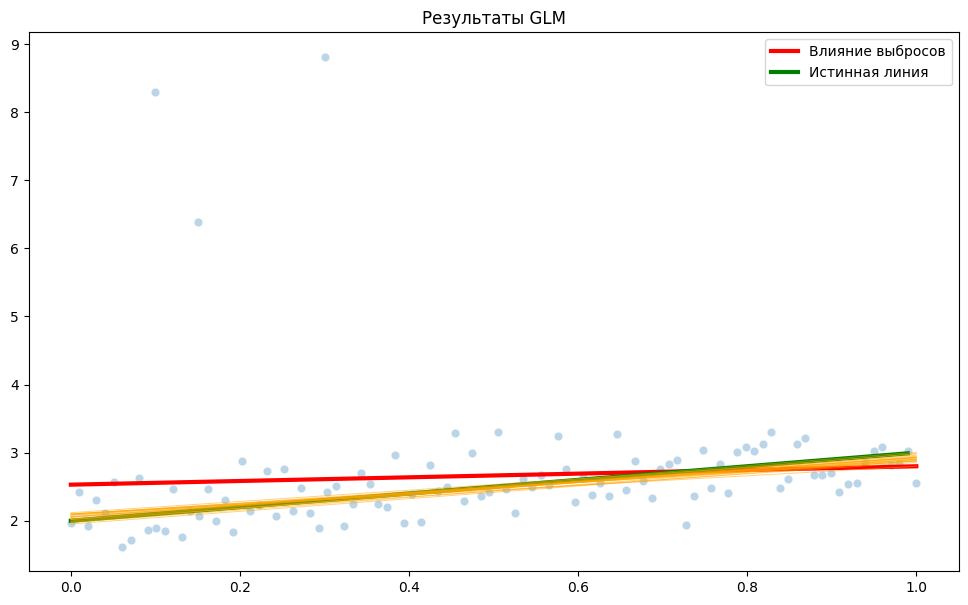

In [35]:
# строим график
plt.figure(figsize=(12, 7))

sns.scatterplot(x=data, y=y_true, alpha=0.3)
sns.lineplot(x=data, y=np.hstack(y_pred), label='Влияние выбросов', linewidth=3, color='red')
sns.lineplot(x=data[:-4], y=y[:-4], label='Истинная линия', linewidth=3, color='green')
plt.plot(data_for_line, robust_lines, color='orange', alpha=0.5, linewidth=0.7, )
plt.title('Результаты GLM')
plt.show()

GLM модель лучше аппрокисимирует точки, которые не являются выбросами. На выбросы же модель обращает меньше внимания по причине использования t-распределения, за счет его тяжелых хвостов подобные аутлайеры считаются нормой. При нормальном же распределении модель "растягивается", чтобы учесть подобные точки как часть нормального распределения

# Confusion feature

Признак, который непосредственно влияет на таргет и другие переменные. 

Например, признак "Наличие электричества". Этот признак влияет как на количество закупаемого керосина, так и количество воска для производства свечей. Если мы исключим признак "Наличие электричества", то обнаружим ложную причино-следствуенную связь между керосином и воском: чем меньше воска, тем меньше керосина, будто один фактор влияет на другой.  
Более известный пример с корреляцией между числом утонувших и числом купленного мороженого. Понятно, что спутывающий признак - лето ли сейчас, но не всегда это так очевидно

In [41]:
np.random.seed(42)
N = 100

# спутывающая перемененная
x_1 = np.random.normal(size=N)

# обычная переменная
x_2 = x_1 + np.random.normal(size=N, scale=1)

# таргет
y = x_1 + np.random.normal(size=N)

# комбо из двух переменных
X = np.stack([x_1, x_2]).T

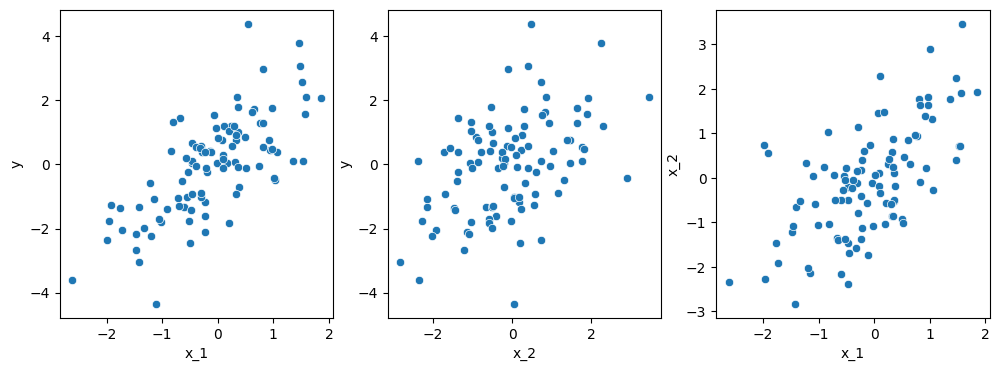

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=False)
sns.scatterplot(x=x_1, y=y, ax=axes[0])
axes[0].set_xlabel('x_1')
axes[0].set_ylabel('y')

sns.scatterplot(x=x_2, y=y, ax=axes[1])
axes[1].set_xlabel('x_2')
axes[1].set_ylabel('y')

sns.scatterplot(x=x_1, y=x_2, ax=axes[2])
axes[2].set_xlabel('x_1')
axes[2].set_ylabel('x_2')
plt.show()

Между <b>x_2</b> и <b>y</b> нет зависимости, одна переменная не влияет на другую, но через <b>x_1</b> возникает довольно сильная корреляция.

Чтобы это доказать или опровергнуть (или просто задуматься) построим три вероятностные модели с одинаковыми распределениями:

1) Первая модель будет содержать обе переменные <b>x_1</b> и <b>x_2</b>
2) Содержит только перменную <b>x_1</b>
3) Содержит только перменную <b>x_2</b>

И, конечно, каждая модель будет сравниваться с таргетом <b>y</b>

In [43]:
# модель для двух переменных

with pm.Model() as model_x1x2:
    
    bias = pm.Normal('bias', mu=0, sigma=10)
    coef_1 = pm.Normal('coef_1', mu=0, sigma=10)
    coef_2 = pm.Normal('coef_2', mu=0, sigma=10)
    noise = pm.HalfCauchy('noise', 10)
    
    mu = bias + coef_1 * X[:,0] + coef_2 * X[:,1]
    
    y_pred = pm.Normal('y_pred_1', mu=mu, sigma=noise, observed=y)
    
    trace_x1x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [bias, coef_1, coef_2, noise]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 75 seconds.


In [44]:
# модель для первой переменной

with pm.Model() as model_x1:
    
    bias = pm.Normal('bias', mu=0, sigma=10)
    coef = pm.Normal('coef_1', mu=0, sigma=10)
    noise = pm.HalfCauchy('noise', 10)
    
    mu = bias + coef * x_1
    
    y_pred = pm.Normal('y_pred_x1', mu=mu, sigma=noise, observed=y)
    
    trace_x1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [bias, coef_1, noise]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 44 seconds.


In [45]:
# модель для второй переменной

with pm.Model() as model_x2:
    
    bias = pm.Normal('bias', mu=0, sigma=10)
    coef = pm.Normal('coef_2', mu=0, sigma=10)
    noise = pm.HalfCauchy('noise', 10)
    
    mu = bias + coef * x_1
    
    y_pred = pm.Normal('y_pred_x2', mu=mu, sigma=noise, observed=y)
    
    trace_x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [bias, coef_2, noise]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 45 seconds.


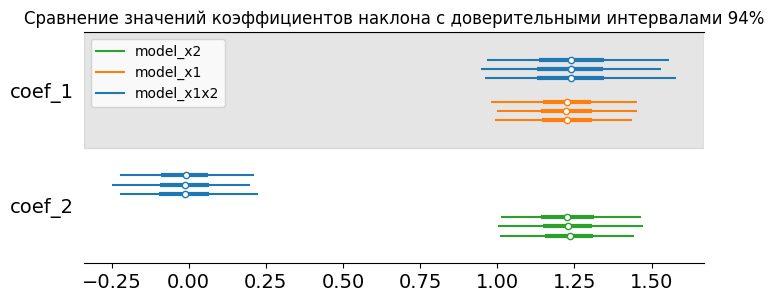

In [46]:
# сравнение коэффициентов 
az.plot_forest(
    [trace_x1x2, trace_x1, trace_x2],
    model_names = ['model_x1x2', 'model_x1', 'model_x2'],
    var_names=['coef_1', 'coef_2'],
    combined=False, figsize=(8,3)
)
plt.title('Сравнение значений коэффициентов наклона с доверительными интервалами 94%')
plt.show()

coef_2 - наша переменная x_2, которая ложно коррелирует с таргетом. Как мы видим, для модели с двумя переменными x1x2, вес x_2 практически равен 0, что значит, что x_2 не оказывает влияние на таргет y

# Сравнение нескольких выборок

В 4 районах города взяты анализы воды на превышение содержания кальция в воде. В каждом районе было взято по 40 образцов

In [65]:
# исходные данные по числу районов
observations = 70
districts = 4
district_ids = np.repeat(np.arange(districts), repeats=observations) #индекс каждого района

In [66]:
district_ids

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [67]:
# генератор выборок
data_generation = lambda p: np.random.binomial(1, p=p, size=observations)

# данные по районам, точнее вероятность получить превышение кальция, т.е.1
np.random.seed(13)
first_district = data_generation(0.30)
second_district = data_generation(0.33)
third_district = data_generation(0.35)
fourth_district = data_generation(0.40)

# объединение в один вектор
total_observations = np.hstack([first_district, second_district, third_district, fourth_district])

Имея номинальные данные (0/1), мы прибегнем к распределению Бернулли. Для этого нам требуется знать вероятность события $p$, которого мы не знаем.  
Но мы знаем, что вероятность лежит в интервале от 0 до 1. Поэтому мы будем получать эту вероятность из Beta-распределения, которое и ограничено таким интервалом (0, 1).  
Так как Beta-распределение имеет параметры $\alpha$ и $\beta$ (число успехов и неуспехов с добавленной 1), которых мы также не знаем, их мы будем генерировать из других распределений. Это будут априорные гиперраспределения.

Параметр $\alpha$ будет состоять из $\mu$ и $\sigma$. $\mu$ берется из Beta-распределения с параметрами 1 и 1, это отражает наше полное априорное незнание этого значения. $\sigma$ отражает уверенность, не может быть отрицательным, поэтому берется из полунормального распределения (X > 0) с достаточно большим разбросом.

Тогда число успехлв (в данном случае число превышений содержания кальция) будет равно
<center>$\alpha = \mu * \sigma$, </center>

а число неуспехов
<center>$\beta = (1 - \mu) * \sigma$, </center>.

Например, мы получили $\mu = 0.3$, а $\sigma = 4$, тогда число успехов $\alpha = 0.3 * 4 = 1.2$, а число неуспехов 
$\beta = (1-0.3) * 4 = 2.8$. 

Теперь на основании этих данных мы будем получать свою собственную вероятность для кажого района, генерировать выборку и сравнивать ее с фактом.



In [68]:
with pm.Model() as water_check:
    
    # генерируются для всех районов
    mu = pm.Beta('mu', 1., 1.)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    alpha = mu * sigma 
    beta = (1 - mu) * sigma
    
    # theta - уникальна для кажого района, потому параметр shape задан как число районов,
    # так для каждого района мы получим свою вероятность
    
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=districts)
    
    # тут сравниваем наши априорные представления с полученными данными
    # индекс параметра p указывает, к какому району относится данная theta
    
    y = pm.Bernoulli('y', p=theta[district_ids], observed=total_observations)
    
    trace_water = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mu, sigma, theta]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 123 seconds.


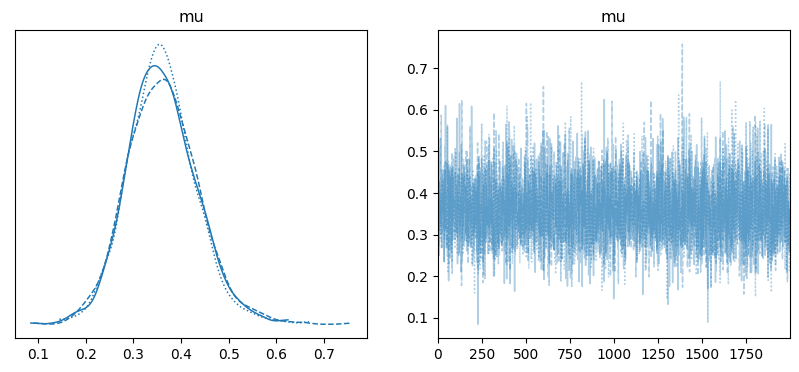

In [69]:
az.plot_trace(trace_water, var_names='mu', figsize=(10,4))
plt.show()

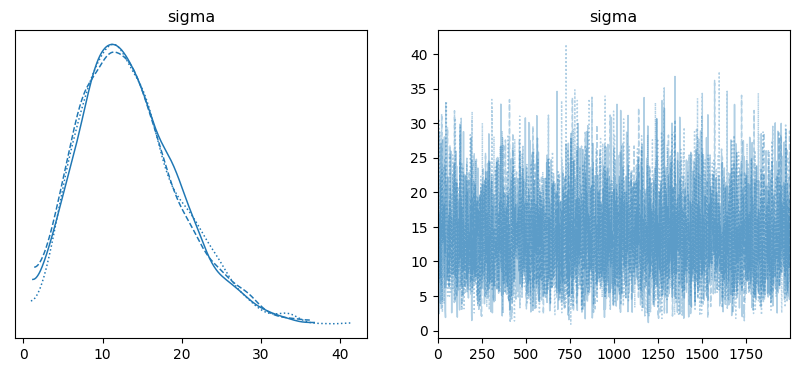

In [70]:
az.plot_trace(trace_water, var_names='sigma', figsize=(10,4))
plt.show()

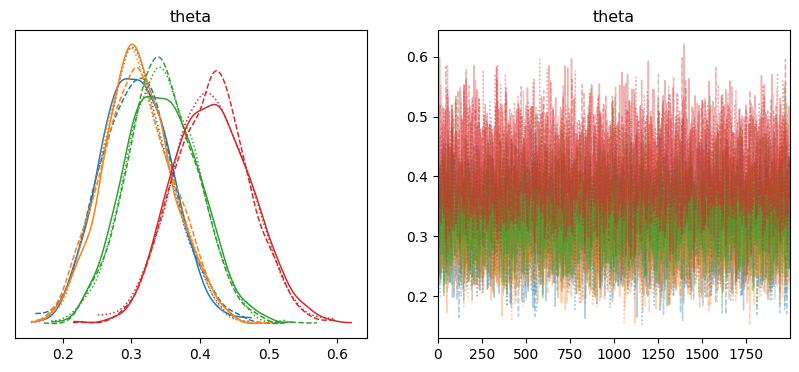

In [71]:
az.plot_trace(trace_water, var_names='theta', figsize=(10,4))
plt.show()

In [72]:
print(f'Среднее число пробирок с превышеним содержания кальция для 1 района {first_district.mean():.2f}')
print(f'Среднее число пробирок с превышеним содержания кальция для 2 района {second_district.mean():.2f}')
print(f'Среднее число пробирок с превышеним содержания кальция для 3 района {third_district.mean():.2f}')
print(f'Среднее число пробирок с превышеним содержания кальция для 4 района {fourth_district.mean():.2f}')

Среднее число пробирок с превышеним содержания кальция для 1 района 0.30
Среднее число пробирок с превышеним содержания кальция для 2 района 0.30
Среднее число пробирок с превышеним содержания кальция для 3 района 0.34
Среднее число пробирок с превышеним содержания кальция для 4 района 0.43


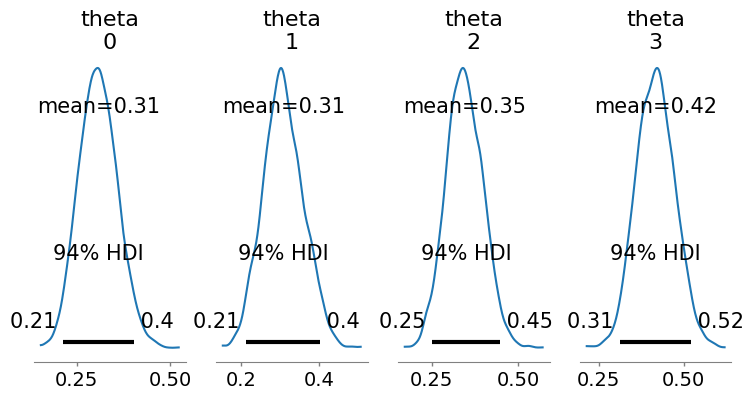

In [84]:
az.plot_posterior(trace_water, var_names='theta', figsize=(9, 4))
plt.show()

На основе полученных результатов мы можем предположить, что содержание кальция в разных районах города различно.  
В районах, где образцы с превышением кальция составляют 30 и 33%, имеют среднюю вероятность (в данном случае, процент образцов с превышеним кальция) 0.31 и доверительные интервалы 0.21-0.4  

Для районов, где 35% и 40% были с превышением кальция, среднее истинное соотношение плохих образцов к хорошим составляет 0.35  и 0.42 с доверительными интервалами: 0.25-0.45 и 0.31-0.52

В данном примере наблюдается редуцирование, то есть обменивание информацией между группами за счет априорного гиперраспределения (параметр theta), например, для групп разными истинными вероятностями средняя вероятность могла быть одинаковая. Редуцирование - то усредненный вариант между независимым исследованием каждого района и совместного исследования как целого города.  

Это менее точный, но более стабильный вариант исследования: т.к. данные, в целом, лучше аппроксимируются, становятся менее чувствительны к аномалиям. Но, если одна выборка будет доминировать над другими, она повлияет на все остальные гораздо сильнее.

# A/B Байесовское тестирование

Фреквентистская статистика просто говорит, что между выборками есть или нет отличий (ялвяются ли различия статистически значимыми). В то же время байесовская статистика сможет сказать, с какой вероятностью одно лучше другого

Самый простой пример: стали ли чаще кликать по кнопке после изменения ее цвета

In [85]:
# вероятности нажатия после изменения цвета
# на практике эти значения неизвестны
p_before = 0.3
p_after = 0.31
np.random.seed(41)

# вероятность, что кнопку нажмут составляет 30%
before_change = np.random.binomial(n=1, p=p_before, size=5000)
after_change = np.random.binomial(n=1, p=p_after, size=1500)

print(f'Число нажатий ДО {before_change.mean():.4f} ')
print(f'Число нажатий ПОСЛЕ {after_change.mean():.4f} ')

Число нажатий ДО 0.2978 
Число нажатий ПОСЛЕ 0.3073 


Мы не знаем истинные вероятности, но мы знаем, что они не могут быть меньше 0 и больше 1

In [86]:
with pm.Model() as ab_test:
    
    p_before_prior = pm.Uniform('p_A', 0, 1)
    p_after_prior = pm.Uniform('p_B', 0, 1)
    
    
    # в нашем случае подойдет распределение Бернулли: сколько кликнуло, сколько нет
    observation_a = pm.Bernoulli('obs_a', p=p_before_prior, observed=before_change)
    observation_b = pm.Bernoulli('obs_b', p=p_after_prior, observed=after_change)
    
    ab_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [p_A, p_B]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 189 seconds.


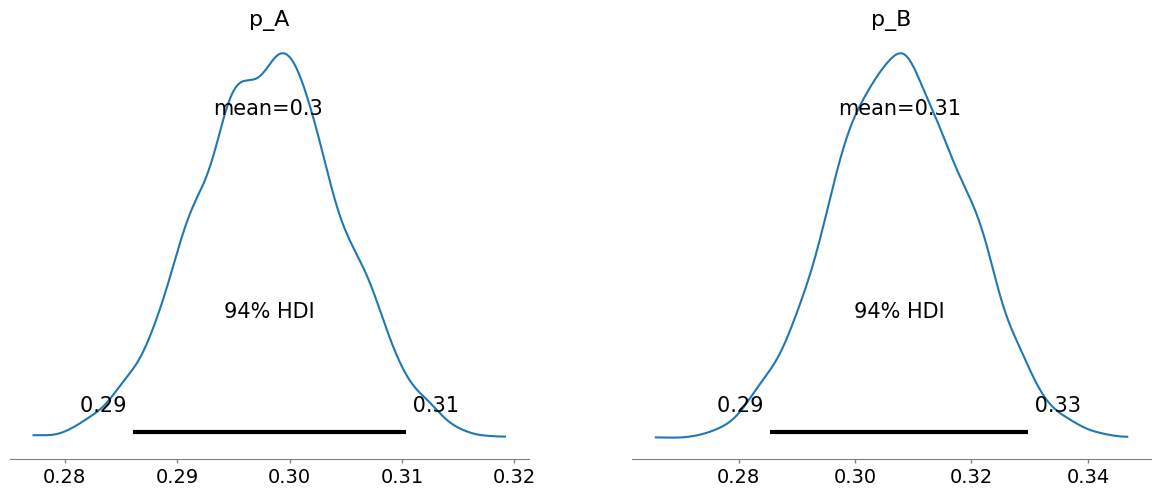

In [87]:
az.plot_posterior(ab_trace)
plt.show()

Мы видим, что для нашего сайта до изменения кнопки доверительный интервал ковнерсии составляет 0.29-0.31, что включает и нашу истинную вероятность (которую мы точно не знаем в реальности). Доверительный интверал на сайте после изменения кнопки шире, он составляет 0.29-0.33, куда также попадает наш интервал в 0.36. Но какой из них лучше?

In [88]:
# проверка через стат тест

click = [before_change.sum(), after_change.sum()]
no_click = [sum(before_change == 0), sum(after_change == 0)]

_, pvalue, *_ = stats.chi2_contingency((click, no_click))

In [89]:
if pvalue < 0.05:
    print('У нас есть основания предполагать, что выборки отличаются')
    print(f'p-value: {pvalue:.4f}')
else:
    print('Выборки не отличаются')
    print(f'p-value: {pvalue:.4f}')

Выборки не отличаются
p-value: 0.5000


Стат тест Хи-Квадрат говорит, что разницы между выборками нет т.е. статистически важного различия мы не наблюдаем, а вероятность получить похожие выборки, если они пришли из одного распределения составляет 50%. Но каковы различия между ними?

<i>P.S. A/B тест составлен некорректно, для обнаружения эффекта в 1% при конверсии в 30% необходимо ~33 000 наблюдений)</i>

In [90]:
values_before = ab_trace.posterior['p_A'].values
values_after = ab_trace.posterior['p_B'].values
diff = (values_after > values_before).mean()
print(f'После изменения цвета кнопки сайт стал лучше в {diff:.1%} случаев')

После изменения цвета кнопки сайт стал лучше в 76.5% случаев


На небольшом объеме данных мы смогли обнаружить положительные различия для второго варианта, с вероятностью 76% он лучше первого варианта. 

# Задача

В воскресенье в кофейню заходят ~15 человек в час. Оценить наиболее вероятное время, когда в кофейню зайдет третий клиент.

In [91]:
lambda_ = 15/60
n_clients = 3

with pm.Model() as chopshop:
    
    y = pm.Gamma('gamma', alpha=n_clients, beta=lambda_, observed=None)
    chopshop_model = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [gamma]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 14 seconds.


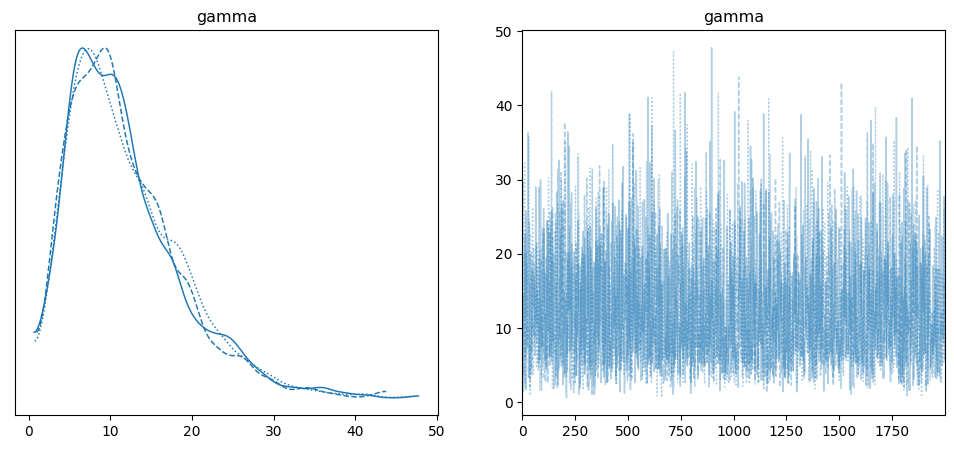

In [92]:
az.plot_trace(chopshop_model, figsize=(12,5))
plt.show()

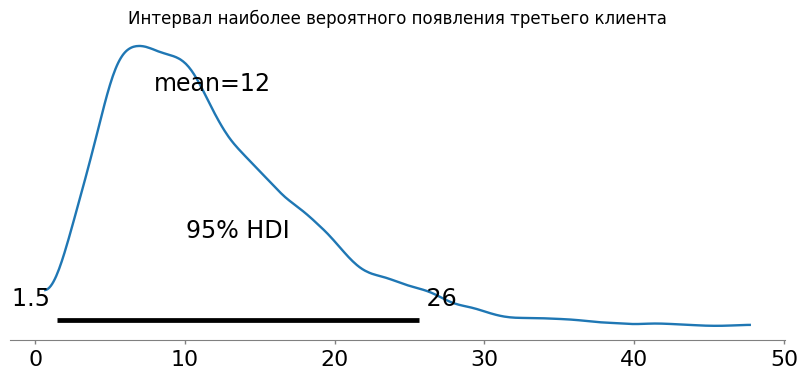

In [97]:
az.plot_posterior(
    chopshop_model,
    var_names='gamma',
    figsize=(10, 4),
    hdi_prob=0.95
)
plt.title('Интервал наиболее вероятного появления третьего клиента')
plt.show()

Наибольшая вероятность появляение третьего клиента сосредоточена в интверале 1.2-26 минут (High density interval), среднее вероятное время составляет 12 минут

А если мы не знаем, что в течение часа заходит 15 человек, а подозреваем, что в среднем заходит 15 +/- 3 человека, причем равновероятно?

In [98]:
n_clients = 3

with pm.Model() as chopshop_2:
    
    lambdas = pm.DiscreteUniform('lambda', lower=15-3, upper=15+3)
    y = pm.Gamma('gamma', alpha=n_clients, beta=lambdas/60, observed=None)
    chopshop_model_2 = pm.sample(2000)

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [lambda]
>NUTS: [gamma]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 16 seconds.


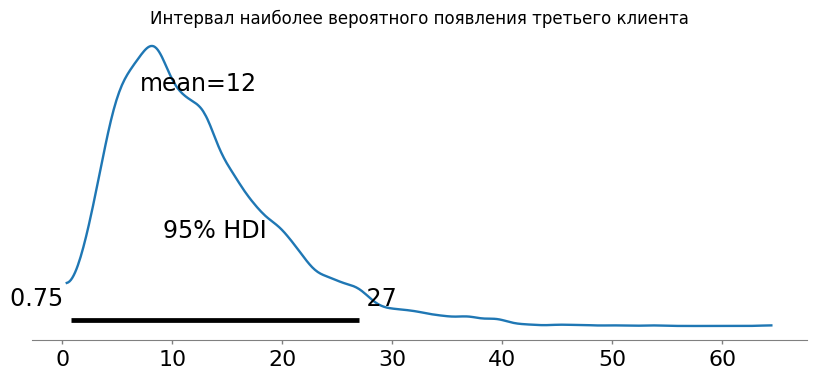

In [99]:
az.plot_posterior(
    chopshop_model_2,
    var_names='gamma',
    figsize=(10, 4),
    hdi_prob=0.95
)
plt.title('Интервал наиболее вероятного появления третьего клиента')
plt.show()

И хотя теперь число посетителей не равняется 15, а колеблется в пределах  12-18 человек, максимальное время ожидания (в 95% случаев) увеличилось только на 1 минуту. Максимальная плотность по-прежнему приблизительно равна 12 минутам

# Еще задача на Гамма-распределение с приблизительными значениями

Механизм может работать, пока не будет поломки в 7 узлах. Подобные узлы ломаются приблизительно в течение 3-6 месяцев. Сколько сможет работать механизм без проведения ремонта?

In [100]:
# gamma: alpha - число событий, beta - lambda(частота событий)

n_nodes = 7
idx=np.arange(n_nodes)
work_time = (90, 180)

with pm.Model() as machine_model:
    
    lambda_ = pm.DiscreteUniform('lambda_', lower=work_time[0], upper=work_time[1], shape=n_nodes)
    gamma = pm.Gamma('gamma', alpha=n_nodes, beta=1/lambda_[idx])
    
    machine_model = pm.sample(2000)

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [lambda_]
>NUTS: [gamma]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 46 seconds.


array([[<AxesSubplot:title={'center':'lambda_'}>,
        <AxesSubplot:title={'center':'lambda_'}>]], dtype=object)

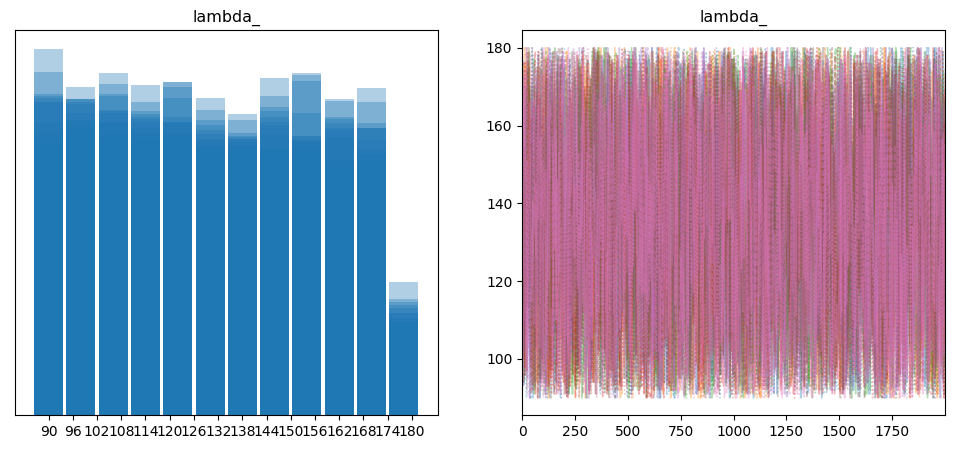

In [101]:
az.plot_trace(machine_model, var_names='lambda_', figsize=(12,5))

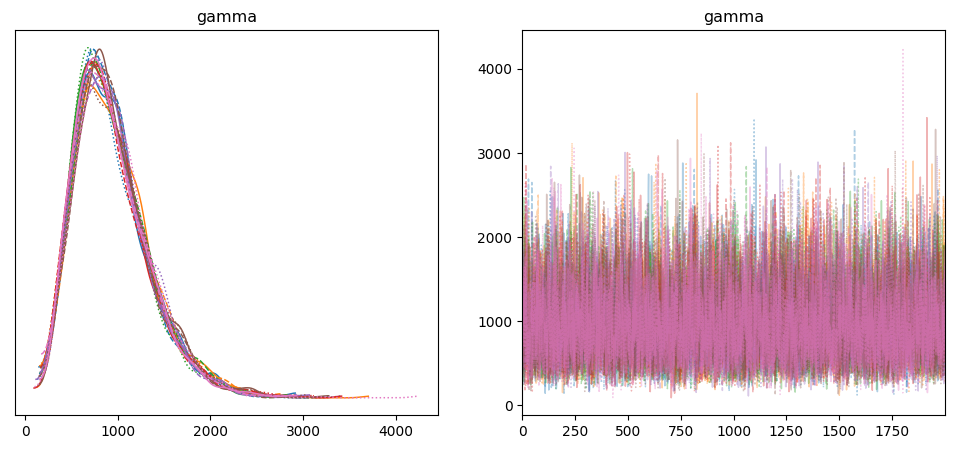

In [104]:
az.plot_trace(machine_model, var_names='gamma', figsize=(12,5))
plt.show()

Наибольшая вероятность лежит между 500 и 1500 днями работы до полной остановки механизма. Максимальная плотность соответствует ~ 800 дням

# Байесовское Ранжирование

In [105]:
def generate_wins(player_1, player_2):
    
    if player_1 == 0 and player_2 == 1:
        return np.random.binomial(n=1, p=0.05)
    if player_1 == 0 and player_2 == 2:
        return np.random.binomial(n=1, p=0.05)
    if player_1 == 1 and player_2 == 0:
        return np.random.binomial(n=1, p=0.9)
    if player_1 == 1 and player_2 == 2:
        return np.random.binomial(n=1, p=0.1)
    if player_1 == 2 and player_2 == 0:
        return np.random.binomial(n=1, p=0.9)
    if player_1 == 2 and player_2 == 1:
        return np.random.binomial(n=1, p=0.85)

In [106]:
games = pd.DataFrame({
    "Player_1": np.random.randint(0, 3, size=1000),
    "Player_2": np.random.randint(0, 3, size=1000)
}
)
games = games[games.eval("Player_1 != Player_2")]

In [107]:
games['Player_1_win'] = games.apply(lambda x: generate_wins(x['Player_1'],  x['Player_2']), axis=1)

In [108]:
games.sample(5)

,Player_1,Player_2,Player_1_win
390,1,0,1
760,0,1,0
470,2,1,1
432,2,1,1
893,2,0,1


In [109]:
# новый игрок, сыгравший только 2 игры
new_games = pd.DataFrame({
    "Player_1": [3, 3],
    "Player_2": [2, 2],
    "Player_1_win": [1, 1]
})
games = pd.concat(
    [games, new_games],
    ignore_index=True
)

Зачем это делать, ведь можно посчитать, сколько раз победил каждый игрок и таким образом определить сильнейших?

In [110]:
games.groupby('Player_1')['Player_1_win'].sum().reset_index()

,Player_1,Player_1_win
0,0,12
1,1,105
2,2,189
3,3,2


Но если игрок #2 победил 184, во сколько раз он лучше игрока #3, который только начал играть, мы не можем сравнить их по частоте побед? А может игрок #2 вовсе не сильный, а просто играл против слабого соперника?

Предположим, что "сила" игроков распределена нормально, со средним - 0 и отклонением 1, то есть, одни игроки преобладают над другими. Генерируем такую силу для каждого игрока, после считаем разницу из сил. Так мы получаем логит.  

Например, для <b>игрока 1</b> из нашего априорного распределения мы получили -2.38, <b>а для игрока 3</b> - -8.43.  

$logit$ = (-2.38) - (-8.43) = 6.05

$\sigma = {1\over 1 + e^(-logit)}= {1 \over 1 + e^(- 6.05)} = 0.9976$

Так мы получили вероятность, что игрок 1 обыграет игрока 2

In [111]:
n_unique_palyer = len(set(games['Player_1'].unique()).union(set(games['Player_2'].unique())))

In [112]:
with pm.Model() as best_gamer:
    
    power = pm.Normal('power', mu=0, sigma=1, shape=n_unique_palyer)
    diff = power[games['Player_1']] - power[games['Player_2']]
    
    observ = pm.Bernoulli('winds', logit_p=diff, observed=games['Player_1_win'])
    
    gamer_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [power]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 262 seconds.


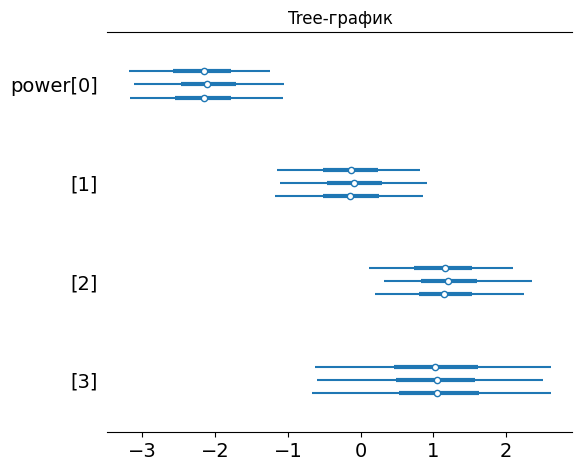

In [114]:
az.plot_forest(gamer_trace)
plt.title('Tree-график')
plt.show()

Игрок 0 как и в сводной таблице, так и в следствие алгоритмов MCMC является самым слабым игроком, а игрок 2 самым сильным. Но вот игрок 3 хоть и сыграл немного игр, доминирует на игроком 1, хотя и с более широкими доверительными интервалами. Но, если бы нам нужно было выставлять кого-то в пару игроку 2, то это был бы игрок 3, а не 1 или 0.

# Сравнение априорного и постериорного распределения


Есть 57 точек из нормального распределения (например, вес участников забега), среднее значение 60 и стандартное отклонение 5. Мы знаем, что вес средний вес около 70 кг со стандартным отклонением 1-3 кг 
Вычислить:
- апостериорное распределение (распределение данных на основе наших знаний)
- априорное распределение (распределение данных по нашему представлению)
- прогнозируемые априорное и апостериорные распределения

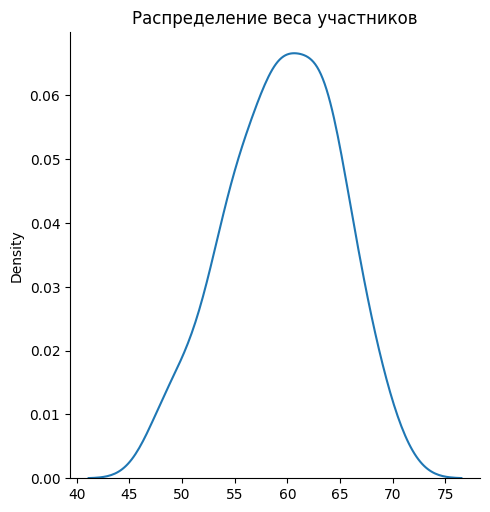

In [117]:
weight = np.random.normal(60, 5, 100)
sns.displot(weight, kind='kde')
plt.title('Распределение веса участников')
plt.show()

In [118]:
with pm.Model() as task_1:
    
    #априорные представления
    mu = pm.Normal('mu', mu=70, sigma=5)
    sigma = pm.HalfNormal('sigma', 3)
    y = pm.Normal('pred', mu=mu, sigma=sigma, observed=weight)
    
    #априорное распределение и предсказание
    prior_pred = pm.sample_prior_predictive()
    
    task_trace = pm.sample(2000)
    
    posterior_pred = pm.sample_posterior_predictive(task_trace)

Sampling: [mu, pred, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mu, sigma]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 31 seconds.
Sampling: [pred]


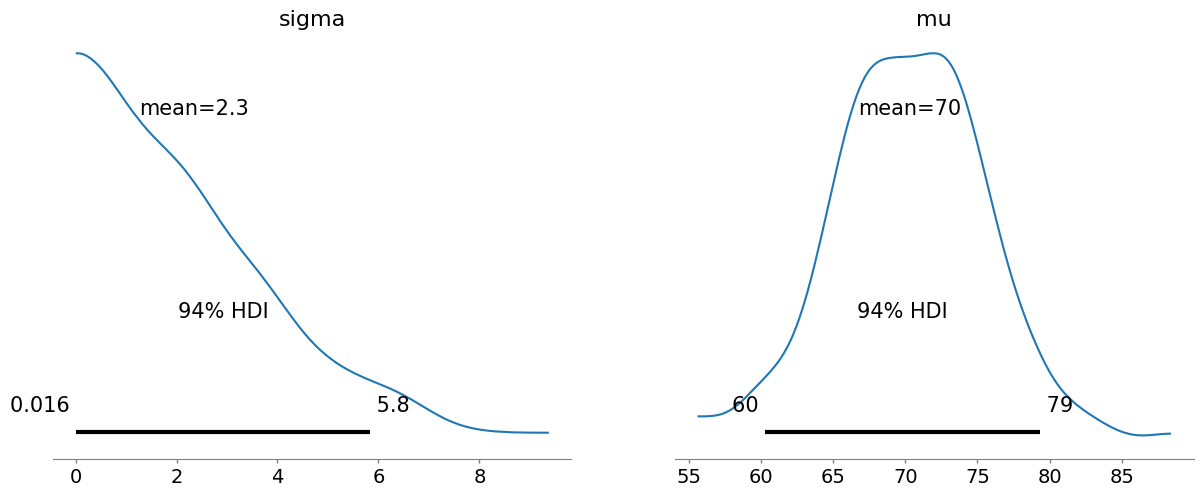

In [122]:
az.plot_posterior(prior_pred.prior)
plt.show()

In [124]:
dataset = pm.sample_posterior_predictive(task_trace,  task_1, random_seed=42)

Sampling: [pred]


Text(0.5, 1.0, 'Постериорное представление')

c:\users\cripe\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


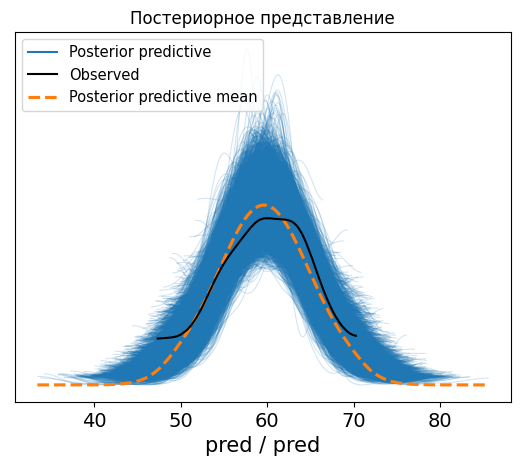

In [125]:
az.plot_ppc(dataset)
plt.title('Постериорное представление')

Предполагая о весе в 70кг, мы тем не менее видим, что 60 кг более вероятное значение. Причем данные настолько убедительны, что наше априорное представление о среднем весе в 70 кг не сместило апостериорное представление вправо, ближе к 70.